In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO, ProdFNO_2D, ProdFNO

from neuralop import Trainer
from neuralop.training import OutputEncoderCallback
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

device = 'cuda'

from neuralop.datasets.autoregressive_dataset import load_autoregressive_traintestsplit
data_path = "/home/yichen/repo/cfd/myFNO/data/zongyi/NavierStokes_V1e-5_N1200_T20.mat"

n_train = 1000
n_test = 200
batch_size = 32
test_batch_size = 64
train_subsample_rate = 1
test_subsample_rate = 1
time_step = 1
train_loader, test_loader = load_autoregressive_traintestsplit(
    data_path,
    n_train, n_test,
    batch_size, test_batch_size, 
    train_subsample_rate, test_subsample_rate,
    time_step,
    predict_feature='u',
)

In [18]:
# We create a tensorized FNO model

input_prods = None
n_modes=21
# model = TFNO(in_channels=3, n_modes=(n_modes, n_modes), hidden_channels=32, 
#              projection_channels=64, factorization='tucker', rank=0.42)
# width=20; num_prod=3
# model = ProdFNO_2D(in_dim=1, appended_dim=4, out_dim=1,
#                modes1=num_modes, modes2=num_modes, width=width, num_prod=num_prod, input_prods=input_prods)
model = ProdFNO(in_channels=3, n_modes=(n_modes, n_modes), hidden_channels=32, 
             projection_channels=64, factorization='tucker', rank=0.42)

model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 688417 parameters.


In [19]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=1e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 ProdFNO(
  (fno_blocks): ProdFNO_Blocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 10, 10), rank=(25, 25, 8, 8))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp): ModuleList(
      (0-3): 4 x ProductLayer(
        (linear): MLP(
          (fcs): ModuleList(
            (0): Conv2d(34, 32, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
    )
    (mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
  

In [20]:
import time
localtime = time.localtime(time.time())
time_now = f"{localtime.tm_mon}-{localtime.tm_mday}-{localtime.tm_hour}-{localtime.tm_min}"

In [21]:
from neuralop.training import MultipleInputCallback, SimpleTensorBoardLoggerCallback
trainer = Trainer(model=model, n_epochs=500,
                  device=device,
                  callbacks=[MultipleInputCallback(append_positional_encoding=True), SimpleTensorBoardLoggerCallback(log_dir='runs/TorisLi_exp_'+time_now,)],             
                  wandb_log=False,
                  log_test_interval=4,
                  use_distributed=False,
                  verbose=True)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [22]:
trainer.train(train_loader=train_loader,
              test_loaders={64: test_loader},
              optimizer=optimizer, 
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss, 
              eval_losses=eval_losses)

Training on 19000 samples
Testing on [3800] samples         on resolutions [64].
Raw outputs of size out.shape=torch.Size([32, 1, 64, 64])
[0] time=8.67, avg_loss=13.7689, train_err=11.5900, 64_h1=0.2769, 64_l2=0.1023
[4] time=8.59, avg_loss=7.4454, train_err=6.2672, 64_h1=0.2017, 64_l2=0.0703
[8] time=8.70, avg_loss=6.4861, train_err=5.4597, 64_h1=0.1739, 64_l2=0.0538
[12] time=8.71, avg_loss=6.0298, train_err=5.0756, 64_h1=0.1628, 64_l2=0.0483
[16] time=8.63, avg_loss=5.7287, train_err=4.8221, 64_h1=0.1564, 64_l2=0.0470
[20] time=8.40, avg_loss=5.4995, train_err=4.6292, 64_h1=0.1463, 64_l2=0.0472
[24] time=8.44, avg_loss=5.3282, train_err=4.4850, 64_h1=0.1445, 64_l2=0.0445
[28] time=8.58, avg_loss=5.1589, train_err=4.3425, 64_h1=0.1373, 64_l2=0.0427
[32] time=8.61, avg_loss=5.0438, train_err=4.2456, 64_h1=0.1353, 64_l2=0.0413
[36] time=8.48, avg_loss=4.9334, train_err=4.1527, 64_h1=0.1337, 64_l2=0.0404
[40] time=8.33, avg_loss=4.8475, train_err=4.0804, 64_h1=0.1323, 64_l2=0.0400
[44]

In [23]:
torch.save(trainer.model, "./ckpt/TorisLi/ProdFNO_ep500.pth")

/tmp/ipykernel_13037/1837442807.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


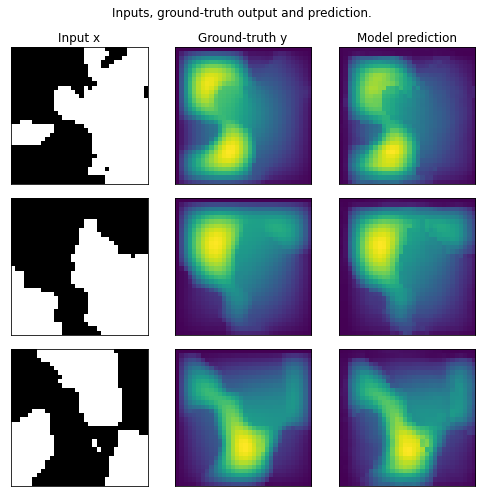

In [8]:
test_samples = test_loader.dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

In [ ]:
/home/yichen/repo/cfd/myFNO/data/ns_contextual/